In [72]:
import pandas as pd
import numpy as np

import os
import sys
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import time

sns.set(style="darkgrid")

In [77]:
cc_data = pd.read_csv('CredCard_with_above50.csv')
cc_data.set_index(['ID'], inplace=True)
cc_data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'above50k'],
      dtype='object')

## Use numerical data

In [91]:
cc_num_data = cc_data.get(key=['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                               'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                               'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

# normalize data
cc_data_norm = cc_num_data.copy()
cc_data_norm = (cc_data_norm - cc_data_norm.min()) / (cc_data_norm.max() - cc_data_norm.min())

In [93]:
cc_data_norm['above50k'] = cc_data.loc[:,'above50k']
cc_data_norm.columns

Index(['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'above50k'],
      dtype='object')

In [94]:
mdata = cc_data_norm.as_matrix()
mdata.shape

(30000, 14)

# Grouping data by the default status

In [96]:
mdata_default = mdata[cc_data['default payment next month'] == 1]
print(mdata_default.shape)
mdata_not_default = mdata[cc_data['default payment next month'] == 0]
print(mdata_not_default.shape)

(6636, 14)
(23364, 14)


## Estimating posterior distributions of each group
The Variational Bayesian Gaussian Mixture Models (VB-GMMs) method estimates the posterior distributions $\lambda_d$ and $\lambda_{nd}$ for the default group and not default group, respectively. 

In [98]:
from sklearn.mixture import BayesianGaussianMixture

model_d = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_process", 
                                  n_components=int(np.sqrt(len(mdata_default))),
                                  reg_covar=0, init_params='random',  max_iter=1500, 
                                  mean_precision_prior=.1, random_state=2)
model_d.weight_concentration_prior = 0.1
print('Estimating posterior distribution for the default group...')
model_d.fit(mdata_default)

model_nd = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_process", 
                                  n_components=int(np.sqrt(len(mdata_not_default))),
                                  reg_covar=0, init_params='random',  max_iter=1500, 
                                  mean_precision_prior=.1, random_state=2)
model_nd.weight_concentration_prior = 0.1
print('Estimating posterior distribution for the not default group...')
model_nd.fit(mdata_not_default)

Estimating posterior distribution for the default group...
Estimating posterior distribution for the not default group...


BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='random',
            max_iter=1500, mean_precision_prior=0.1, mean_prior=None,
            n_components=152, n_init=1, random_state=2, reg_covar=0,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=0.1,
            weight_concentration_prior_type='dirichlet_process')

# Compute the log of posterior probabilities
Now, we compute $\log p(\lambda_d|Data)$ and $\log p(\lambda_{nd}|Data)$

[ True  True  True ...,  True  True  True]


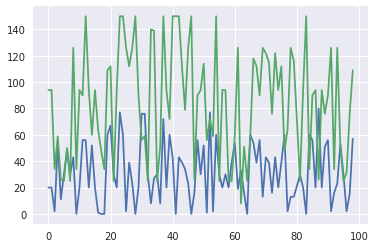

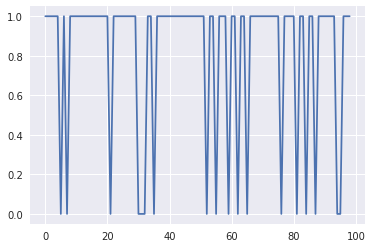

In [99]:
pos_prob_d = model_d.predict(mdata)
pos_prob_nd = model_nd.predict(mdata)

import pickle
pickle.dump(model_d, open('default_model.mdl', 'wb'))
pickle.dump(model_nd, open('not_default_model.mdl', 'wb'))

loaded_model_d = pickle.load(open('default_model.mdl', 'rb'))
loaded_model_nd = pickle.load(open('not_default_model.mdl', 'rb'))

pos_prob_d = loaded_model_d.predict(mdata)
pos_prob_nd = loaded_model_nd.predict(mdata)

print(pos_prob_nd > pos_prob_d)

plt.plot(pos_prob_d[1:100]) #blue
plt.plot(pos_prob_nd[1:100]) #green
plt.show()

plt.plot(pos_prob_nd[1:100] > pos_prob_d[1:100])
plt.show()

# Using tSNE as a feature extractor 

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random',
            random_state=2, perplexity=5)
mdata_tsne_transform = tsne.fit_transform(mdata)

KeyboardInterrupt: 

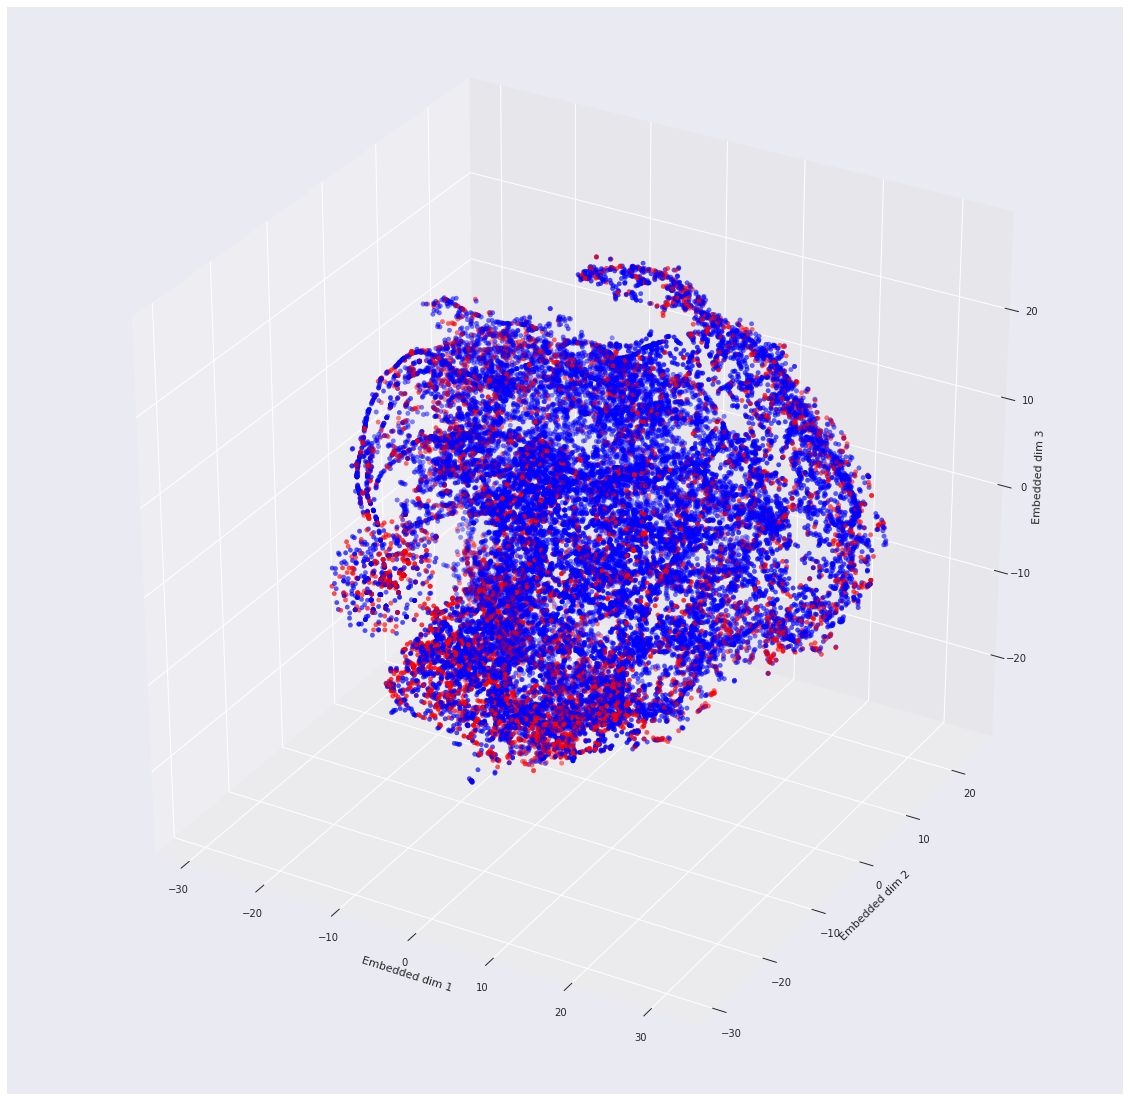

In [70]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
color_dict = {0: 'b', 1: 'r'}

ax.scatter(mdata_tsne_transform[:,0], mdata_tsne_transform[:,1], mdata_tsne_transform[:,2], 
           c=[color_dict[label] for label in cc_data['default payment next month'].values])
ax.set_xlabel('Embedded dim 1')
ax.set_ylabel('Embedded dim 2')
ax.set_zlabel('Embedded dim 3')
plt.show()